# Create 3d clone of the scene

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [57]:
def convert_to_homogeneous(points):
    n = points.shape[0]
    return np.concatenate((points, np.ones((n,1))), axis=1)

In [58]:
def convert_to_cartesian(points):
    return points[:,:-1]

In [59]:
def normalize_and_homogenize_2d(points):
    centroid = np.mean(points, axis=0)
    centred_points = points - centroid
    scale = np.sqrt(2) / np.mean(np.linalg.norm(centred_points, axis=1))
    T = np.array([[scale, 0, -centroid[0] * scale],
                  [0, scale, -centroid[1] * scale],
                  [0, 0, 1]])
    points = np.dot(T, convert_to_homogeneous(points).T).T
    return points, T

In [60]:
def normalize_and_homogenize_3d(points):
    centroid = np.mean(points, axis=0)
    centred_points = points - centroid
    scale = np.sqrt(3) / np.mean(np.linalg.norm(centred_points, axis=1))
    T = np.array([[scale, 0, 0, -centroid[0] * scale],
                  [0, scale, 0, -centroid[1] * scale],
                  [0, 0, scale, -centroid[2] * scale],
                  [0, 0, 0, 1]])
    points = np.dot(T, convert_to_homogeneous(points).T).T
    return points, T

In [61]:
points_3d = np.array([[372, 808,   0],
                      [321, 807,   0],
                      [320, 548,   0],
                      [372, 808, 100],
                      [321, 807, 100],
                      [320, 548, 100],
                      [251, 805,   0],
                      [200, 806,   0],
                      [251, 805, 100],
                      [200, 806, 100]])
points_3d, N3 = normalize_and_homogenize_3d(points_3d)
points_3d = convert_to_cartesian(points_3d)
print(points_3d)
print(np.mean(np.linalg.norm(points_3d, axis=1)))
print(np.mean(points_3d, axis=0))

[[ 1.14458679  0.7688386  -0.72259267]
 [ 0.40754227  0.75438675 -0.72259267]
 [ 0.39309041 -2.98864329 -0.72259267]
 [ 1.14458679  0.7688386   0.72259267]
 [ 0.40754227  0.75438675  0.72259267]
 [ 0.39309041 -2.98864329  0.72259267]
 [-0.60408747  0.72548304 -0.72259267]
 [-1.341132    0.7399349  -0.72259267]
 [-0.60408747  0.72548304  0.72259267]
 [-1.341132    0.7399349   0.72259267]]
1.7320508075688772
[-2.66453526e-16  0.00000000e+00  0.00000000e+00]


In [62]:
points_2d = np.array([[1932, 1314],
                      [1556, 1332],
                      [1412,  524],
                      [2071,  772],
                      [1619,  764],
                      [1432,  257],
                      [ 942, 1355],
                      [ 546, 1336],
                      [ 760,  777],
                      [ 407,  803]])
points_2d, N2 = normalize_and_homogenize_2d(points_2d)
points_2d = convert_to_cartesian(points_2d)
print(points_2d)
print(np.mean(np.linalg.norm(points_2d[:,:2], axis=1)))
print(np.mean(points_2d[:,:2], axis=0))

[[ 1.4784385   0.86930314]
 [ 0.64162851  0.9093632 ]
 [ 0.32114809 -0.88888806]
 [ 1.78779113 -0.33694955]
 [ 0.7818387  -0.35475402]
 [ 0.36565926 -1.48311217]
 [-0.7248644   0.96055104]
 [-1.60618556  0.91826543]
 [-1.12991604 -0.32582176]
 [-1.91553819 -0.26795724]]
1.4142135623730951
[-4.4408921e-17  4.4408921e-17]


In [63]:
n = points_2d.shape[0]
u = points_2d[:,0]
v = points_2d[:,1]
X = points_3d[:,0]
Y = points_3d[:,1]
Z = points_3d[:,2]
A = np.zeros((2*n, 12))

In [64]:
for i in range(n):
    A[2*i,:] = [X[i], Y[i], Z[i], 1, 0, 0, 0, 0, -u[i]*X[i], -u[i]*Y[i], -u[i]*Z[i], -u[i]]
    A[2*i+1,:] = [0, 0, 0, 0, X[i], Y[i], Z[i], 1, -v[i]*X[i], -v[i]*Y[i], -v[i]*Z[i], -v[i]]

## DLT algorithm

In [65]:
U, S, V = np.linalg.svd(A)

In [66]:
P = V[-1].reshape((3, 4))

In [67]:
P

array([[-0.57556511,  0.03843564,  0.00935864, -0.04306508],
       [ 0.01800434, -0.39107181,  0.37715259,  0.14186805],
       [ 0.00378313,  0.18979871,  0.06490066, -0.55625842]])

## Evaluate

In [69]:
def evaluate_points(M, Points_2D, Points_3D):

    reshaped_points = np.concatenate(
        (Points_3D, np.ones((Points_3D.shape[0], 1))), axis=1)
    Projection = np.matmul(M, np.transpose(reshaped_points))
    Projection = np.transpose(Projection)
    u = np.divide(Projection[:, 0], Projection[:, 2])
    v = np.divide(Projection[:, 1], Projection[:, 2])
    Residual = np.sum(
        np.power(
            np.power(u - Points_2D[:, 0], 2) +
            np.power(v - Points_2D[:, 1], 2), 0.5))
    Projected_2D_Pts = np.transpose(np.vstack([u, v]))

    return Projected_2D_Pts, Residual

def visualize_points(Actual_Pts, Project_Pts):
    plt.scatter(Actual_Pts[:, 0], Actual_Pts[:, 1], marker='o')
    plt.scatter(Project_Pts[:, 0], Project_Pts[:, 1], marker='x')
    plt.legend(('Actual Points', 'Projected Points'))
    plt.show()

In [80]:
pts, res = evaluate_points(P, points_2d, points_3d)
print(res)

0.7912170091971891


In [81]:
if 'renorm':
    pts = convert_to_cartesian(np.dot(np.linalg.inv(N2), convert_to_homogeneous(pts).T).T)
    points_2d = convert_to_cartesian(np.dot(np.linalg.inv(N2), convert_to_homogeneous(points_2d).T).T)

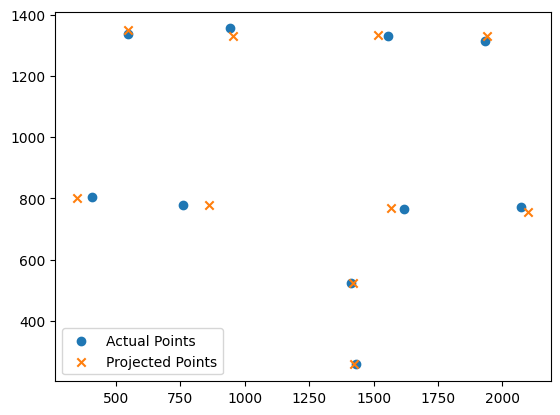

In [82]:
visualize_points(points_2d, pts)

## Camera Centre

In [127]:
def compute_camera_center(P):
    Q = np.split(P, [3], axis=1)
    return np.squeeze(-np.matmul(np.linalg.inv(Q[0]), Q[1]))

In [128]:
cen = compute_camera_center(P)

In [129]:
def plot3dview(Points_3D, camera_center1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Points_3D[:, 0],
               Points_3D[:, 1],
               Points_3D[:, 2],
               c='b',
               marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.elev = 31
    ax.azim = -129

    # draw vertical lines connecting each point to Z=0
    min_z = np.min(Points_3D[:, 2])
    for i in range(0, Points_3D.shape[0]):
        ax.plot(np.array([Points_3D[i, 0], Points_3D[i, 0]]),
                np.array([Points_3D[i, 1], Points_3D[i, 1]]),
                np.array([Points_3D[i, 2], min_z]))

    # if camera_center1 exists, plot it
    if 'camera_center1' in locals():
        ax.scatter(camera_center1[0],
                   camera_center1[1],
                   camera_center1[2],
                   s=100,
                   c='r',
                   marker='x')
        ax.plot(np.array([camera_center1[0], camera_center1[0]]),
                np.array([camera_center1[1], camera_center1[1]]),
                np.array([camera_center1[2], min_z]),
                c='r')

    plt.show()

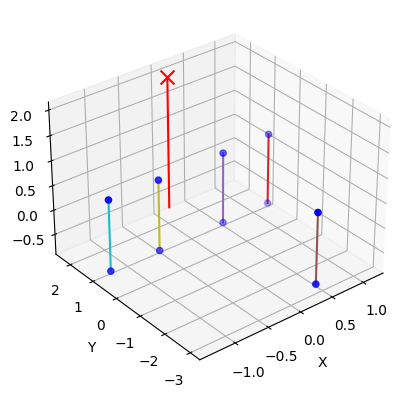

In [131]:
plot3dview(points_3d, cen)

## Pseudo Inverse

In [190]:
point = np.array([[1932, 1314]])
point_norm = np.dot(N2, convert_to_homogeneous(point).T).T
point_norm

array([[1.4784385 , 0.86930314, 1.        ]])

In [199]:
point_ray = np.dot(np.linalg.pinv(P), point_norm.T).T

In [200]:
cen

array([0.10785984, 2.25830222, 1.9603427 ])

In [201]:
point_ray = point_ray / point_ray[:,3]
point_ray

array([[ 1.30645131,  0.49482473, -1.15203195,  1.        ]])

In [202]:
v = point_ray[:,0:3] - cen
v

array([[ 1.19859147, -1.76347749, -3.11237465]])

In [203]:
t = (-0.72259267-cen[2]) / v[0,2]
print(t)

0.8620219848540452


In [204]:
point_ray = cen + t * v[:, :3]
point_ray

array([[ 1.14107204,  0.73814585, -0.72259267]])

In [209]:
convert_to_cartesian(np.dot(np.linalg.inv(N3), convert_to_homogeneous(point_ray).T).T)

array([[3.71756796e+02, 8.05876207e+02, 8.54874642e-08]])

In [206]:
[372, 808,   0]

[372, 808, 0]

In [215]:
(np.dot(N3, np.array([0, 0, 0, 1])))[2]

-0.7225926712354523

In [218]:
def get_world_point(P, image_point, height):
    cen = compute_camera_center(P)
    point_norm = np.dot(N2, convert_to_homogeneous(image_point).T).T
    point_ray = np.dot(np.linalg.pinv(P), point_norm.T).T
    point_ray = point_ray / point_ray[:,3]
    v = point_ray[:,0:3] - cen
    h = (np.dot(N3, np.array([0, 0, height, 1])))[2]
    t = (-0.72259267-cen[2]) / v[0,2]
    point_ray = cen + t * v[:, :3]
    world_point = convert_to_cartesian(np.dot(np.linalg.inv(N3), convert_to_homogeneous(point_ray).T).T)
    return world_point.astype(int) 

In [221]:
get_world_point(P, np.array([[546, 1336]]), 0)

array([[198, 804,   0]])